# Ordinary Differential Equations in 1D Solutions

## Import Statements

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import root_scalar

## Introducing the Model Equation

In the world of computational science, researchers often start with simpler models to understand underlying behaviors and test numerical schemes. For ODEs, one of the simplest possible systems is single-variable exponential decay.

$$
\begin{align}
\frac{\mathrm{d} u}{\mathrm{d} t} &= f(u, t) = - \alpha u \\
u(0) &= u_{0} \\
\alpha &\geq 0
\end{align}
$$

- This is an autonomous system, since the derivative doesn't depend on time. If $u(t)$ is a solution, so is $u(t - t_{0})$.
- The solution is known exactly, $u(t) = u_{0} e^{-\alpha t}$. This is helpful for error analysis.
- Since the analytical solution should decay smoothly and asymptotically towards 0, it is easy to spot bad behaviors.

In [2]:
# IVP constraints
alpha = 1
u0 = 1

In [3]:
# Differential equation
f = np.vectorize(lambda u, t: -alpha * u)

In [4]:
# So-called Jacobian, derivative of ODE with respect to dependent variables
df_dy = np.vectorize(lambda u, t: -alpha)

In [5]:
# Analytical solution
u = np.vectorize(lambda t: u0 * np.exp(-alpha * t))

## Solution Methods

Implement the forward and backward Euler methods. You have probably seen these in Calculus.

In [6]:
# Implement forward Euler method
def forward_euler(f, tspan: tuple, y0, dt: float):
    """Integrate a system of ODE's using the forward Euler method.
    
    Arguments:
    f: a scalar- or vector-valued differential equation in the form y' = f(y, t)
    tspan: a tuple of (t0, tf)
    x0: the value at the initial time
    dt: the time step
    
    Returns:
    A tuple of time steps and corresponding solution vectors.
    
    Note: this is not necessarily recommended for very large systems.
    """
    t = tspan[0]
    y = y0
    ts = [tspan[0]] # Might be prudent to pre-allocate these arrays
    ys = [y0]
    while t < tspan[1]:
        y += dt * f(y, t)
        t += dt
        ts += [t]
        ys += [y]
    return (ts, ys)

The backward Euler method is a bit trickier because it is defined implicitly. Implicit means that in general, there is no forward computation to find your answer.

$$
\begin{align*}
y_{n + 1} &= y_{n} + \Delta t f(y_{n + 1}, t_{n + 1})
\end{align*}
$$

Granted, for our model equation, an explicit solution is possible. Can you derive it?

$$
\begin{align*}
y_{n + 1} &= \frac{1}{1 - \Delta t \alpha} y_{n}
\end{align*}
$$

However, our integration function doesn't know this. The solution is to rehash our implicit equation as a root-finding problem.

$$
\begin{align*}
F(z) &= z - y_{n} - \Delta t f(z, t_{n + 1}) \\
&= 0 \implies z = y_{n + 1} \\
F'(z) &= 1 - \Delta t f'(z, t_{n + 1})
\end{align*}
$$

Root-finding is often done with what's called Newton iteration or the tangent method. A guess is made by drawing a tangent to the x-axis from the current guesss.

$$
\begin{align*}
F'(z_{n}) &= \frac{0 - F(z_{n})}{z_{n + 1} - z_{n}} \\
z_{n + 1} &= z_{n} - \frac{F(z_{n})}{F'(z_{n})}
\end{align*}
$$

It is important to understand that this method technically does not always converge, especially if you give it a poor first guess. If, sor some reason, you land somewhere where $F' = 0$, the method fails! Nevertheless, it is common in practice, and we will use it here.

In [7]:
# Implement backward Euler method
def backward_euler(f, df_dy, tspan: tuple, y0, dt: float):
    """Integrate a system of ODE's using the backward Euler method.
    
    Arguments:
    f: a scalar- or vector-valued differential equation in the form y' = f(y, t)
    tspan: a tuple of (t0, tf)
    x0: the value at the initial time
    dt: the time step
    
    Returns:
    A tuple of time steps and corresponding solution vectors.
    
    Note: this is not necessarily recommended for very large systems.
    """
    t = tspan[0]
    y = y0
    ts = [tspan[0]] # Might be prudent to pre-allocate these arrays
    ys = [y0]
    while t < tspan[1]:
        # Problem: backward Euler is implicitly defined
        # f(y[n + 1], t[n + 1]) is not known yet
        # We will use Newton's method
        F = np.vectorize(lambda z: z - y - dt * f(z, t + dt))
        dF_dz = np.vectorize(lambda z: 1 - dt * df_dy(z, t + dt))
        y = root_scalar(
            F,
            x0=y + dt * f(y, t),
            fprime=dF_dz,
            rtol=1e-6,
            method='newton'
        ).root # root_scalar() returns an object, so extract the z-value
        t += dt
        ts += [t]
        ys += [y]
    return (ts, ys)

## Stability

Stability refers to whethter a particular methoud causes the approximate solution to blow up to unrealistically large values. Often a certain range for cobinations of the problem parameters and simulation discretizations has to be satisfied. For example, in fluid mechanics, a common one is the Courant number, which describes how many cells a signal travels across in one time step. In general, and somewhat intuitively, it should be less than 1, but the basis for such rules is in mathematics. In this case, the quantity of interest is the discretization size times the decay parameter, $h \alpha$. Can you derive why?

Solve the model problem on $0 \leq t \leq 10$ for $h = 2.5, 2, 1, 0.5$. Plot all of them on the same graph against the analytical solution. What do you observe?

In [8]:
# Get solutions
hs = [2.5, 2, 1, 0.5]
solutions_forward = [] # List of tuples, [(ts1, us1), (ts2, us2), ...]
solutions_backward = []

for h in hs:
    solutions_forward += [forward_euler(f, (0, 10), u0, h)]
    solutions_backward += [backward_euler(f, df_dy, (0, 10), u0, h)]

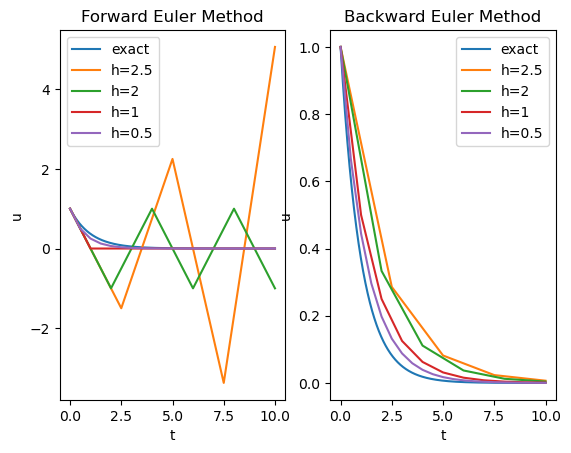

In [9]:
# Plot solutions
fig, axs = plt.subplots(1, 2)
ts = np.linspace(0, 10, 1001)
# Plot analytical solution
axs[0].plot(ts, u(ts), label='exact')
axs[1].plot(ts, u(ts), label='exact')
# Plot numerical solutions
for i in range(len(hs)):
    axs[0].plot(solutions_forward[i][0], solutions_forward[i][1], label=f'h={hs[i]}')
    axs[1].plot(solutions_backward[i][0], solutions_backward[i][1], label=f'h={hs[i]}')
axs[0].set_title('Forward Euler Method')
axs[0].set_xlabel('t')
axs[0].set_ylabel('u')
axs[0].legend()
axs[1].set_title('Backward Euler Method')
axs[1].set_xlabel('t')
axs[1].set_ylabel('u')
axs[1].legend()
plt.show()

## Accuracy

Accuracy refers to how far off your approximate solution is from the true solution. Of particular interest is how fast the solution converges by improving discretization. Some methods give you more bang for your buck, but tend to involve more computations (flops).

Solve the model problem on $0 \leq t \leq 10$ for $h = 0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125$. Compute the absolute value of the error of the solution at $t = 10$, since error accumulates with every discrete step. If the exact solution was not known, you might study instead the relative error between a finer and coarser discretization, or just take a high-resolution solution as the ground truth. Plot these showing that forward and backward Euler methods are bot first-order. Use a log-log plot of inverse time step (number of time points?) against error.

In [10]:
# Get solutions
hs = [2.5, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0071825, 0.00359125, 0.001795625]
solutions_forward = [] # List of tuples, [(ts1, us1), (ts2, us2), ...]
solutions_backward = []

for h in hs:
    solutions_forward += [forward_euler(f, (0, 10), u0, h)]
    solutions_backward += [backward_euler(f, df_dy, (0, 10), u0, h)]

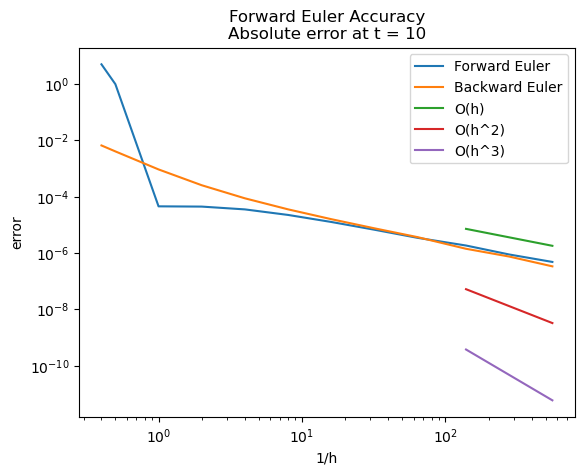

In [11]:
# Plot errors
fig, ax = plt.subplots()
errs_forward = []
errs_backward = []
for i in range(len(hs)):
    errs_forward += [np.abs(solutions_forward[i][1][-1] - u0 * np.exp(-alpha * 10))]
    errs_backward += [np.abs(solutions_backward[i][1][-1] - u0 * np.exp(-alpha * 10))]
invhs = [1 / h for h in hs]
ax.loglog(invhs, errs_forward, label='Forward Euler')
ax.loglog(invhs, errs_backward, label='Backward Euler')
hhs = [0.0071825, 0.00359125, 0.001795625]
invhhs = [1 / hh for hh in hhs]
ax.loglog(invhhs, [0.001 * hh for hh in hhs], label='O(h)')
ax.loglog(invhhs, [0.001 * hh**2 for hh in hhs], label='O(h^2)')
ax.loglog(invhhs, [0.001 * hh**3 for hh in hhs], label='O(h^3)')
ax.set_title('Forward Euler Accuracy\nAbsolute error at t = 10')
ax.set_xlabel('1/h')
ax.set_ylabel('error')
ax.legend()
plt.show()